### AGENDA
1. logic about rays (namedtuple, sampling along rays) ==> RESOLVED
2. step function works in semantic loss?
3. test dataloader ==> SOLVED!
4. how to sample random pose in this settings? ==> RESOLVED
5. reshape in image can recover original image?? ==> YES!

In [1]:
import jax.numpy as jnp
import numpy as np
import jax
import pandas as pd
import matplotlib.pyplot as plt

from jaxnerf.nerf.datasets import Blender

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class dset_config:
    split = "train"
    use_pixel_centers = 0.
    batch_size = 16
    render_path = None
    max_steps = 10
    clip_downsample_factor = 2
    data_dir = "/media/alex/Amazing/personal/Project/HuggingfaceJAX/nerf_synthetic/nerf_synthetic/ficus"
    factor = 2
    precompute_pkl_path = "/media/alex/Amazing/personal/Project/HuggingfaceJAX/nerf_synthetic/nerf_synthetic/ficus/clip_cache_train_factor4_float16.pkl"
    white_bkgd = True
    batching = "single_image"
    far = 6
    near = 2

In [3]:
dataset = Blender('train', dset_config)

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


In [4]:
dataset.rays.origins.shape, dataset.images.shape

((100, 160000, 3), (100, 160000, 3))

### 1. Reshape can recover one image? ==> YES!

In [5]:
from PIL import Image

In [6]:
one_image = dataset.images[0]
one_image.shape

(160000, 3)

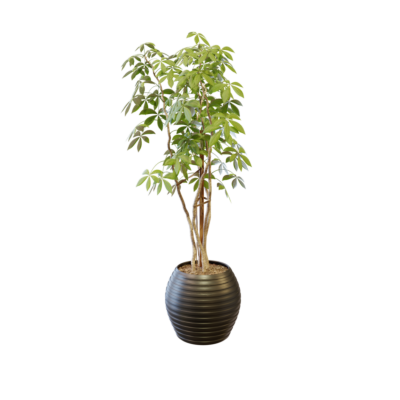

In [7]:
im = (one_image.reshape([400, 400, 3]) * 255.).astype(np.uint8)
im = Image.fromarray(im)
im

### 2. Logic of Rays

In [8]:
from jaxnerf.nerf import utils

In [9]:
dataset.rays.origins.shape

(100, 160000, 3)

In [10]:
dataset.rays.origins[0, 0]

array([0.54986286, 3.9353192 , 0.6789065 ], dtype=float32)

In [11]:
ray_indices = np.random.randint(0, dataset.rays[0][0].shape[0],
                                (dataset.batch_size,))
len(ray_indices)

16

In [12]:
batch_rays = utils.namedtuple_map(lambda r: r[8][ray_indices], dataset.rays)
batch_rays.origins.shape

(16, 3)

In [13]:
dataset.camtoworlds.shape

(100, 4, 4)

In [14]:
dataset.camtoworlds[0]

array([[-9.9037921e-01, -2.3305541e-02,  1.3640420e-01,  5.4986286e-01],
       [ 1.3838083e-01, -1.6679566e-01,  9.7623265e-01,  3.9353192e+00],
       [-1.8626454e-09,  9.8571599e-01,  1.6841599e-01,  6.7890650e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

### 3. What is the output of Random Pose?

In [15]:
from jaxnerf.nerf.clip_utils import random_pose

In [16]:
rng = jax.random.PRNGKey(0)
camtoworlds = random_pose(rng, (2, 6))
camtoworlds.shape

(4, 4)

In [17]:
self = dataset

pixel_center = 0.
x, y = np.meshgrid(  # pylint: disable=unbalanced-tuple-unpacking
    np.arange(self.w, dtype=np.float32) + pixel_center,  # X-Axis (columns)
    np.arange(self.h, dtype=np.float32) + pixel_center,  # Y-Axis (rows)
    indexing="xy")
camera_dirs = np.stack([(x - self.w * 0.5) / self.focal,
                        -(y - self.h * 0.5) / self.focal, -np.ones_like(x)],
                       axis=-1)
camera_dirs.shape

(400, 400, 3)

In [18]:
camera_dirs[None, ..., None, :].shape, self.camtoworlds[:, None, None, :3, :3].shape

((1, 400, 400, 1, 3), (100, 1, 1, 3, 3))

In [19]:
(camera_dirs[None, ..., None, :] * self.camtoworlds[:, None, None, :3, :3]).shape

(100, 400, 400, 3, 3)

In [20]:
_directions = (camera_dirs[..., None, :] * camtoworlds[None, None, :3, :3]).sum(axis=-1)
_origins = np.broadcast_to(camtoworlds[None, None, :3, -1], _directions.shape)
_viewdirs = _directions / np.linalg.norm(_directions, axis=-1, keepdims=True)
_directions.shape, _origins.shape, _viewdirs.shape

((400, 400, 3), (400, 400, 3), (400, 400, 3))

In [21]:
random_rays = dataset.camtoworld_matrix_to_rays(random_pose(rng, (2, 6)))

In [22]:
random_rays.origins.shape, random_rays.directions.shape, random_rays.viewdirs.shape

((400, 400, 3), (400, 400, 3), (400, 400, 3))

### 4. Test DataLoader

In [23]:
batch = dataset.peek()
batch.keys()

dict_keys(['embedding', 'image_index', 'pixels', 'random_rays', 'rays'])

In [24]:
type(batch["random_rays"].viewdirs), type(batch["random_rays"].directions)

(numpy.ndarray, numpy.ndarray)

In [25]:
batch["random_rays"].directions.dtype

dtype('float32')

In [26]:
for idx, _batch in enumerate(dataset):
    if idx == 10:
        break

In [27]:
batch["pixels"].shape

(1, 16, 3)

### 5. Test Step Function

In [28]:
from jaxnerf.nerf import clip_utils
from jaxnerf.train import train_step

detected device: [<jaxlib.xla_extension.Device object at 0x7f390307def0>]


In [29]:
clip_model = clip_utils.init_CLIP(dtype='float32', model_name=None)

In [30]:
clip_model

In [31]:
import flax
import jax.numpy as jnp
from jax import random

from jaxnerf.nerf import models
from jaxnerf.nerf import utils


In [32]:
from jaxnerf.nerf import utils

In [33]:
lr_init = 5e-4
model_flags = utils.flags.FLAGS
model_flags.factor = 2
model_flags.batch_size = 16

rng, key = random.split(rng)
model, variables = models.get_model(key, dataset.peek(), model_flags)
optimizer = flax.optim.Adam(lr_init).create(variables)
state = utils.TrainState(optimizer=optimizer)

In [39]:
_batch["rays"].origins.shape

(1, 16, 3)

In [37]:
_ = train_step(model, clip_model, step=10, sc_loss_eval_step=10, 
               rng=rng, state=state, batch=batch, lr=lr_init)

[autoreload of jaxnerf.nerf.model_utils failed: Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/flax/linen/module.py", line 

> /home/alex/Desktop/hugginface_jax_flax/google-research/jaxnerf/nerf/model_utils.py(96)cast_rays()
     94     from pdb import set_trace
     95     set_trace()
---> 96     return origins[..., None, :] + z_vals[..., None] * directions[..., None, :]
     97 
     98 

ipdb> origins.shape
(1, 16, 3)
ipdb> u
> /home/alex/Desktop/hugginface_jax_flax/google-research/jaxnerf/nerf/model_utils.py(136)sample_along_rays()
    134         z_vals = jnp.broadcast_to(z_vals[None, ...], [batch_size, num_samples])
    135 
--> 136     coords = cast_rays(z_vals, origins, directions)
    137     return z_vals, coords
    138 

ipdb> ll
     99 def sample_along_rays(key, origins, directions, num_samples, near, far,
    100                       randomized, lindisp):
    101     """
    102     Stratified sampling along the rays.
    103 
    104     Args:
    105         key: jnp.ndarray, random generator key.
    106         origins: jnp.ndarray(float32), [batch_size, 3], ray origins.
    107         d

ipdb> rays
Rays(origins=array([[[ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269],
        [ 3.1952379,  2.4574223, -0.0391269]]], dtype=float32), directions=array([[[-0.9497148 , -0.40569326, -0.01009288],
        [-0.753015  , -0.65861297,  0.16809872],
        [-0.57474935, -0.8961899 , -0.19548416],
        [-0.9802395 , -0.36104602,  0.30129248],
        [-0.599

BdbQuit: 

In [40]:
%debug

> /home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/jax/_src/lax/lax.py(3680)_concatenate_shape_rule()
   3678            "dimension {} for shapes {}.")
   3679     shapes = [operand.shape for operand in operands]
-> 3680     raise TypeError(msg.format(dimension, ", ".join(map(str, shapes))))
   3681 
   3682   concat_size = sum(o.shape[dimension] for o in operands)

ipdb> u
> /home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py(2886)<listcomp>()
   2884   else:
   2885     while len(arrays) > 1:
-> 2886       arrays = [lax.concatenate(arrays[i:i+k], axis)
   2887                 for i in range(0, len(arrays), k)]
   2888     return arrays[0]

    [... skipped 11 hidden frame(s)]

ipdb> u
> /home/alex/anaconda3/envs/diet-nerf/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py(2886)concatenate()
   2884   else:
   2885     while len(arrays) > 1:
-> 2886       arrays = [lax.concatenate(arrays[i:i+k], axis)
   2887                 